In [17]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=3, shuffle=True, random_state=42)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [18]:
# Importing 2019, 2018, 2017 flight status info datasets
ONTIME_REPORTING_2019 = pd.DataFrame()
for i in range(1,13):
    file_name = "ONTIME_REPORTING_2019_" + str(i) + ".csv"
    ONTIME_REPORTING_2019 = pd.concat([ONTIME_REPORTING_2019, pd.read_csv(file_name)], ignore_index=True)
ONTIME_REPORTING_2019 = ONTIME_REPORTING_2019.drop(columns='Unnamed: 9')

ONTIME_REPORTING_2018 = pd.DataFrame()
for i in range(1,13):
    file_name = "ONTIME_REPORTING_2018_" + str(i) + ".csv"
    ONTIME_REPORTING_2018 = pd.concat([ONTIME_REPORTING_2018, pd.read_csv(file_name)], ignore_index=True)
ONTIME_REPORTING_2018 = ONTIME_REPORTING_2018.drop(columns='Unnamed: 9')

ONTIME_REPORTING_2017 = pd.DataFrame()
for i in range(11,13):
    file_name = "ONTIME_REPORTING_2017_" + str(i) + ".csv"
    ONTIME_REPORTING_2017 = pd.concat([ONTIME_REPORTING_2017, pd.read_csv(file_name)], ignore_index=True)
ONTIME_REPORTING_2017 = ONTIME_REPORTING_2017.drop(columns='Unnamed: 9')

In [19]:
# Check missing values
flights = pd.concat([ONTIME_REPORTING_2017, ONTIME_REPORTING_2018, ONTIME_REPORTING_2019], ignore_index=True)
flights.isnull().sum()

FL_DATE                   0
OP_UNIQUE_CARRIER         0
TAIL_NUM              32687
OP_CARRIER_FL_NUM         0
ORIGIN                    0
DEST                      0
DEP_DELAY            253823
DEP_TIME_BLK              0
CRS_ELAPSED_TIME        145
dtype: int64

In [20]:
# Remove missing values
flights = flights.dropna()
flights.isnull().sum()

FL_DATE              0
OP_UNIQUE_CARRIER    0
TAIL_NUM             0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
DEP_DELAY            0
DEP_TIME_BLK         0
CRS_ELAPSED_TIME     0
dtype: int64

## Model

In [21]:
# Set up models
lr = LinearRegression(n_jobs=-1)
lasso = Lasso()
ridge = Ridge(random_state=42)
knn = KNeighborsRegressor(n_jobs=-1)
tree = DecisionTreeRegressor(random_state=42)
xgboost = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

model_list = ['lr', 'lasso', 'ridge', 'knn', 'tree', 'xgboost']

## Model 1

In [22]:
# Select flight status info of Delta Airlines at Atlanta Airport
# Remove extreme delay time (outliers), the threshold is 180 minutes 
# Split training data (2017.11 - 2019.11) and test data (2019.11, 2019.12)
# Select 5% of the data for the model building 
flights_train = flights[(flights.OP_UNIQUE_CARRIER == "DL") & (flights.ORIGIN == "ATL") & (flights.DEP_DELAY < 180) & (flights.FL_DATE < '2019-11-01')].sample(frac=0.05, replace=False, random_state=8)
flights_test = flights[(flights.OP_UNIQUE_CARRIER == "DL") & (flights.ORIGIN == "ATL") & (flights.DEP_DELAY < 180) & (flights.FL_DATE >= '2019-11-01')].sample(frac=0.05, replace=False, random_state=8)

In [23]:
# 24152 rows for training, 1957 rows for testing
print(flights_train.shape, flights_test.shape)

(24152, 9) (1957, 9)


In [24]:
# Select features for modeling
# Transform categorical features to dummies
flights_model_train = flights_train[["DEP_TIME_BLK", "CRS_ELAPSED_TIME", "DEP_DELAY"]]
flights_model_train = pd.get_dummies(flights_model_train)
flights_model_test = flights_test[["DEP_TIME_BLK", "CRS_ELAPSED_TIME", "DEP_DELAY"]]
flights_model_test = pd.get_dummies(flights_model_test)

# Set target variables
y_train_atl = flights_model_train["DEP_DELAY"]
X_train_atl = flights_model_train.drop(columns=["DEP_DELAY"])

y_test_atl = flights_model_test["DEP_DELAY"]
X_test_atl = flights_model_test.drop(columns=["DEP_DELAY"])

In [25]:
# Model 1: the base model with features only from flights status info dataset
model_1_scores = list()
for model in ([lr, lasso, ridge, knn, tree, xgboost]):
    score = cross_val_score(model, X_train_atl, y_train_atl, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    print("score: ", round(-score.mean(), 2), " +/- ", round(-score.std(), 2))
    model_1_scores.append(round(-score.mean(), 2))

score:  445.75  +/-  -10.07
score:  453.87  +/-  -10.23
score:  445.75  +/-  -10.07
score:  529.15  +/-  -15.34
score:  530.92  +/-  -7.14
score:  471.62  +/-  -12.57


In [26]:
# Save model 1 scores
model_1_scores_results = pd.DataFrame({'model': model_list, 'score': model_1_scores})
model_1_scores_results

,model,score
0,lr,445.75
1,lasso,453.87
2,ridge,445.75
3,knn,529.15
4,tree,530.92
5,xgboost,471.62


# Feature Engineering

In [27]:
# Combine the flights info with plane info and airport info
inventory = pd.read_csv('B43_INVENTORY.csv', encoding='latin1')
inventory = inventory.drop(columns="Unnamed: 3")
airport = pd.read_csv("AIRPORT.csv")
airport = airport.rename(columns={'Description':'AIRPORT_NAME'})

flights_train = pd.merge(flights_train, inventory, left_on='TAIL_NUM', right_on='TAIL_NUMBER')
flights_test = pd.merge(flights_test, inventory, left_on='TAIL_NUM', right_on='TAIL_NUMBER')

In [28]:
# Create the features of year, month and day_of_week from the flight dates
flights_train["FL_DATE"] = pd.to_datetime(flights_train.FL_DATE)
flights_train["YEAR"] = flights_train.FL_DATE.dt.year
flights_train["MONTH"] = flights_train.FL_DATE.dt.month.astype(str)
flights_train["DAY_OF_WEEK"] = flights_train.FL_DATE.dt.weekday.astype(str)
# Create the feature of the plane age
flights_train['PLANE_AGE'] = 2019 - flights_train.MANUFACTURE_YEAR
# Create the feature of the number of flights that depart in the same time block of a day at an airport
FLIGHT_BLK_NUM = flights_train.groupby(['ORIGIN','FL_DATE', 'DEP_TIME_BLK'])['OP_CARRIER_FL_NUM'].count().reset_index()
flights_train = pd.merge(flights_train, FLIGHT_BLK_NUM, on=['ORIGIN', 'FL_DATE', 'DEP_TIME_BLK'])

# Create the features of year, month and day_of_week from the flight dates
flights_test["FL_DATE"] = pd.to_datetime(flights_test.FL_DATE)
flights_test["YEAR"] = flights_test.FL_DATE.dt.year
flights_test["MONTH"] = flights_test.FL_DATE.dt.month.astype(str)
flights_test["DAY_OF_WEEK"] = flights_test.FL_DATE.dt.weekday.astype(str)
# Create the feature of the plane age
flights_test['PLANE_AGE'] = 2019 - flights_test.MANUFACTURE_YEAR
# Create the feature of the number of flights that depart in the same time block of a day at an airport
FLIGHT_BLK_NUM = flights_test.groupby(['ORIGIN','FL_DATE', 'DEP_TIME_BLK'])['OP_CARRIER_FL_NUM'].count().reset_index()
flights_test = pd.merge(flights_test, FLIGHT_BLK_NUM, on=['ORIGIN', 'FL_DATE', 'DEP_TIME_BLK'])

In [29]:
# Drop unneccessary columns and only keep the features we want for the model
flights_train = flights_train.rename(columns={'OP_CARRIER_FL_NUM_y':'FLIGHT_BLK_NUM'})
flights_train = flights_train[['DEP_DELAY', 'FL_DATE', 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK',
'CRS_ELAPSED_TIME', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'FLIGHT_BLK_NUM']]

flights_test = flights_test.rename(columns={'OP_CARRIER_FL_NUM_y':'FLIGHT_BLK_NUM'})
flights_test = flights_test[['DEP_DELAY', 'FL_DATE', 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK',
'CRS_ELAPSED_TIME', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'FLIGHT_BLK_NUM']]

## Model 2

In [30]:
# Select features for modeling
# Transform categorical features to dummies
flights_model_train = flights_train[['DEP_DELAY', 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK',
'CRS_ELAPSED_TIME', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'FLIGHT_BLK_NUM']]
flights_model_train = pd.get_dummies(flights_model_train)
flights_model_test = flights_test[['DEP_DELAY', 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK',
'CRS_ELAPSED_TIME', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'FLIGHT_BLK_NUM']]
flights_model_test = pd.get_dummies(flights_model_test)

# Set target variables
y_train_atl = flights_model_train["DEP_DELAY"]
X_train_atl = flights_model_train.drop(columns=["DEP_DELAY"])

y_test_atl = flights_model_test["DEP_DELAY"]
X_test_atl = flights_model_test.drop(columns=["DEP_DELAY"])

In [31]:
# Model 2: features from flights status data and plane info data
model_2_scores = list()
for model in ([lr, lasso, ridge, knn, tree, xgboost]):
    score = cross_val_score(model, X_train_atl, y_train_atl, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    print("score: ", round(-score.mean(), 2), " +/- ", round(-score.std(), 2))
    model_2_scores.append(round(-score.mean(), 2))

score:  440.29  +/-  -3.16
score:  454.47  +/-  -4.69
score:  440.28  +/-  -3.16
score:  529.6  +/-  -3.62
score:  927.21  +/-  -8.16
score:  488.1  +/-  -4.91


In [32]:
# Save model 2 scores
model_2_scores_results = pd.DataFrame({'model': model_list, 'score': model_2_scores})
model_2_scores_results

,model,score
0,lr,440.29
1,lasso,454.47
2,ridge,440.28
3,knn,529.60
4,tree,927.21
5,xgboost,488.10


# Joining Weather Data

In [33]:
# Prepare the weather datasets
# Removing unnecessary features
# Fill out the categorical features with 0 and 1
# Transform some features from floats to integers for dummy transformation
# Change the type of date to datetime 
weather = pd.read_csv("WEATHER_ATL.csv")
weather = weather.drop(columns=["PGTM", "WDF2", "WDF5", "STATION", "NAME"]).fillna(0)
weather["WT01"] = weather.WT01.astype('uint8')
weather["WT02"] = weather.WT02.astype('uint8')
weather["WT03"] = weather.WT03.astype('uint8')
weather["WT04"] = weather.WT04.astype('uint8')
weather["WT05"] = weather.WT05.astype('uint8')
weather["WT08"] = weather.WT08.astype('uint8')
weather['DATE'] = pd.to_datetime(weather.DATE)

In [34]:
# Join flights data with weater data
flights_train = pd.merge(flights_train, weather, left_on="FL_DATE", right_on="DATE")
flights_test = pd.merge(flights_test, weather, left_on="FL_DATE", right_on="DATE")

## Model 3

In [35]:
# Select features for modeling
# Transform categorical features to dummies
flights_model_train = flights_train.drop(columns=["FL_DATE", "DATE"])
flights_model_train = pd.get_dummies(flights_model_train)
flights_model_test = flights_test.drop(columns=["FL_DATE", "DATE"])
flights_model_test = pd.get_dummies(flights_model_test)

# Set target variables
y_train_atl = flights_model_train["DEP_DELAY"]
X_train_atl = flights_model_train.drop(columns=["DEP_DELAY"])

y_test_atl = flights_model_test["DEP_DELAY"]
X_test_atl = flights_model_test.drop(columns=["DEP_DELAY"])

In [36]:
# Model 3: Model with features of flight data and weather data
model_3_scores = list()
for model in ([lr, lasso, ridge, knn, tree, xgboost]):
    score = cross_val_score(model, X_train_atl, y_train_atl, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    print("score: ", round(-score.mean(), 2), " +/- ", round(-score.std(), 2))
    model_3_scores.append(round(-score.mean(), 2))

score:  413.13  +/-  -34.02
score:  437.61  +/-  -40.86
score:  413.14  +/-  -34.06
score:  508.22  +/-  -29.48
score:  823.09  +/-  -24.35
score:  422.76  +/-  -28.85


In [37]:
# Save model 3 scores
model_3_scores_results = pd.DataFrame({'model': model_list, 'score': model_3_scores})
model_3_scores_results

,model,score
0,lr,413.13
1,lasso,437.61
2,ridge,413.14
3,knn,508.22
4,tree,823.09
5,xgboost,422.76


# Standardization

In [38]:
# Standarlize the data
sc = StandardScaler()
sc.fit(X_train_atl)
X_train_atl_sc = sc.transform(X_train_atl)

## Model 4

In [39]:
# Model 4: Model with standardized data
model_4_scores = list()
for model in ([lr, lasso, ridge, knn, tree, xgboost]):
    score = cross_val_score(model, X_train_atl_sc, y_train_atl, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    print("score: ", round(-score.mean(), 2), " +/- ", round(-score.std(), 2))
    model_4_scores.append(round(-score.mean(), 2))

score:  413.09  +/-  -34.09
score:  431.04  +/-  -39.95
score:  413.13  +/-  -34.02
score:  465.32  +/-  -31.45
score:  822.12  +/-  -22.84
score:  422.84  +/-  -28.86


In [40]:
# Save model 4 scores
model_4_scores_results = pd.DataFrame({'model': model_list, 'score': model_4_scores})
model_4_scores_results

,model,score
0,lr,413.09
1,lasso,431.04
2,ridge,413.13
3,knn,465.32
4,tree,822.12
5,xgboost,422.84


# Feature Selection

In [41]:
# Create a function for feature selection
# Use sequential forward selection
# Return the peformance table with selected features and cv scores in each step
def feature_selection(model, train_data):
    sfs_model = SFS(model, k_features=X_train_atl.shape[1], forward=True, floating=False, verbose=2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    sfs_model = sfs_model.fit(train_data, y_train_atl)
    sfs_model_results = pd.DataFrame.from_dict(sfs_model.get_metric_dict()).T
    sfs_model_results['avg_score'] = np.abs(sfs_model_results['avg_score'])
    return(sfs_model_results)

In [ ]:
# Apply the function to different models
# Use standardized data for knn
# Warning: it takes about 2 hours with 12 cores to finish 
sfs_lr_results = feature_selection(lr, X_train_atl)
sfs_lasso_results = feature_selection(lasso, X_train_atl)
sfs_ridge_results = feature_selection(ridge, X_train_atl)
sfs_tree_results = feature_selection(tree, X_train_atl)
sfs_xgboost_results = feature_selection(xgboost, X_train_atl)

sfs_knn_results = feature_selection(knn, X_train_atl_sc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    0.1s finished

[2021-10-02 12:37:47] Features: 1/56 -- score: -443.6949455640497[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished

[2021-10-02 12:37:47] Features: 2/56 -- score: -437.7565597881838[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.1s finished

[2021-10-02 12:37:47] Features: 3/56 -- score: -432.885105858049[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_job

In [39]:
# Save the feature selection results to the working directory
sfs_lr_results.to_csv("sfs_lr_results.csv")
sfs_lasso_results.to_csv("sfs_lasso_results.csv")
sfs_ridge_results.to_csv("sfs_ridge_results.csv")
sfs_knn_results.to_csv("sfs_knn_results.csv")
sfs_tree_results.to_csv("sfs_tree_results.csv")
sfs_xgboost_results.to_csv("sfs_xgboost_results.csv")

In [42]:
# Import the feature selection results to the working directory 
sfs_lr_results = pd.read_csv("sfs_lr_results.csv")
sfs_lasso_results = pd.read_csv("sfs_lasso_results.csv")
sfs_ridge_results = pd.read_csv("sfs_ridge_results.csv")
sfs_knn_results = pd.read_csv("sfs_knn_results.csv")
sfs_tree_results = pd.read_csv("sfs_tree_results.csv")
sfs_xgboost_results = pd.read_csv("sfs_xgboost_results.csv")

In [43]:
# Combine the feature selection results together
sfs_results = pd.DataFrame({
    'num_of_features': range(1, X_train_atl.shape[1]+1),
    'lr': sfs_lr_results['avg_score'],
    'lasso': sfs_lasso_results['avg_score'],
    'ridge': sfs_ridge_results['avg_score'],
    'knn': sfs_knn_results['avg_score'],
    'tree': sfs_tree_results['avg_score'],
    'xgboost': sfs_xgboost_results['avg_score']
})

sfs_results = pd.melt(sfs_results, id_vars=['num_of_features'], var_name='models', value_name='MSE score')

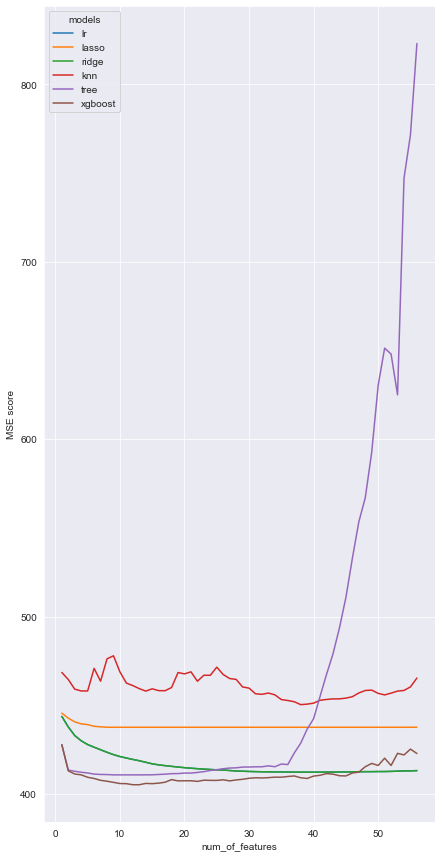

In [44]:
# Create a lineplot of the MSE score against the change of feature numbers
plt.figure(figsize=(7, 15))
sns.set_style("darkgrid")
sns.lineplot(data=sfs_results, x="num_of_features", y="MSE score", hue="models");

In [45]:
# Save feature selection scores
sfs_scores = [
    sfs_lr_results['avg_score'].min(),
    sfs_lasso_results['avg_score'].min(),
    sfs_ridge_results['avg_score'].min(),
    sfs_knn_results['avg_score'].min(),
    sfs_tree_results['avg_score'].min(),
    sfs_xgboost_results['avg_score'].min()]
sfs_scores = [round(score, 2) for score in sfs_scores]

In [46]:
# Create a function for subsetting data with selected features
def train_data_select(sfs, train_data):
    pd.options.display.max_colwidth = 1000
    features_model = sfs.sort_values('avg_score')[:1]['feature_idx'].to_string()
    features_model = [int(i) for i in features_model[7:-1].split(',')]
    if isinstance(train_data, pd.DataFrame):
        return(train_data.iloc[:, features_model])
    else:
        train_data = pd.DataFrame(train_data)
        return(train_data.iloc[:, features_model])

In [47]:
# Apply the function to different models
# Use standardized data for knn
X_train_atl_lr = train_data_select(sfs_lr_results, X_train_atl)
X_train_atl_lasso = train_data_select(sfs_lasso_results, X_train_atl)
X_train_atl_ridge = train_data_select(sfs_ridge_results, X_train_atl)
X_train_atl_tree = train_data_select(sfs_tree_results, X_train_atl)
X_train_atl_xgboost = train_data_select(sfs_xgboost_results, X_train_atl)

X_train_atl_knn = train_data_select(sfs_knn_results, X_train_atl_sc)
X_train_atl_lr_sc = train_data_select(sfs_lr_results, X_train_atl_sc)

# Hyperparameter Tuning

In [48]:
# Hyperparameter tuning for Lasso
lasso_gs = GridSearchCV(
    estimator=lasso, 
    param_grid=[{
        'alpha': [0.001, 0.01, 0.1, 1]
        }],
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1)

lasso_gs = lasso_gs.fit(X_train_atl_lasso, y_train_atl)

print("MSE Score: ", round(-lasso_gs.best_score_, 2))
print("Optimal Parameter: ", lasso_gs.best_params_)

MSE Score:  422.89
Optimal Parameter:  {'alpha': 0.001}


In [50]:
# Hyperparameter tuning for Ridge
ridge_gs = GridSearchCV(
    estimator=ridge, 
    param_grid=[{
        'alpha': [0.001, 0.01, 0.1, 1]
        }],
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1)

ridge_gs = ridge_gs.fit(X_train_atl_ridge, y_train_atl)

print("MSE Score: ", round(-ridge_gs.best_score_, 2))
print("Optimal Parameter: ", ridge_gs.best_params_)

MSE Score:  412.27
Optimal Parameter:  {'alpha': 0.001}


In [51]:
# Hyperparameter tuning for KNN
knn_gs = GridSearchCV(
    estimator=knn, 
    param_grid=[{
        'n_neighbors': [25, 35, 45, 55, 65]
        }],
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1)

knn_gs = knn_gs.fit(X_train_atl_knn, y_train_atl)

print("MSE Score: ", round(-knn_gs.best_score_, 2))
print("Optimal Parameter: ", knn_gs.best_params_)

MSE Score:  421.24
Optimal Parameter:  {'n_neighbors': 45}


In [52]:
# Hyperparameter tuning for Tree
tree_gs = GridSearchCV(
    estimator=tree, 
    param_grid=[{
        "max_depth": [10, 15, 25],
        'min_samples_leaf': [1, 3, 5],
        'min_impurity_decrease': [0.001, 0.005, 0.01]
        }],
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1)

tree_gs = tree_gs.fit(X_train_atl_tree, y_train_atl)

print("MSE Score: ", round(-tree_gs.best_score_, 2))
print("Optimal Parameter: ", tree_gs.best_params_)

MSE Score:  410.47
Optimal Parameter:  {'max_depth': 15, 'min_impurity_decrease': 0.005, 'min_samples_leaf': 3}


In [53]:
# Hyperparameter tuning for xgboost
xgboost_gs = GridSearchCV(
    estimator=xgboost, 
    param_grid=[{
        "max_depth": [5, 10, 15],
        'n_estimators': [20, 25, 30],
        'learning_rate': [0.05, 0.1, 0.15]
        }],
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1)

xgboost_gs = xgboost_gs.fit(X_train_atl_xgboost, y_train_atl)

print("MSE Score: ", round(-xgboost_gs.best_score_, 2))
print("Optimal Parameter: ", xgboost_gs.best_params_)

MSE Score:  396.49
Optimal Parameter:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 25}


In [54]:
# Save hyperparameter tuning scores
gs_scores = [
    sfs_scores[0],
    -lasso_gs.best_score_,
    -ridge_gs.best_score_,
    -knn_gs.best_score_,
    -tree_gs.best_score_,
    -xgboost_gs.best_score_,
]

gs_scores = [round(score, 2) for score in gs_scores]

# Improvement of performance

In [55]:
# Model scores with steps above
score_results = pd.DataFrame({
    'models': model_list, 
    'base_model': model_1_scores_results['score'],
    'feature_engineering': model_2_scores_results['score'],
    'weather_data': model_3_scores_results['score'],
    'standardization': model_4_scores_results['score'],
    'feature_selection': sfs_scores,
    'hyperparameter_tuning': gs_scores
    }
)

score_results_melt = pd.melt(
    score_results, id_vars=['models'], 
    var_name='steps', value_name='MSE score')

In [56]:
score_results

,models,base_model,feature_engineering,weather_data,standardization,feature_selection,hyperparameter_tuning
0,lr,445.75,440.29,413.13,413.09,412.27,412.27
1,lasso,453.87,454.47,437.61,431.04,437.57,422.89
2,ridge,445.75,440.28,413.14,413.13,412.27,412.27
3,knn,529.15,529.60,508.22,465.32,450.34,421.24
4,tree,530.92,927.21,823.09,822.12,410.73,410.47
5,xgboost,471.62,488.10,422.76,422.84,405.17,396.49


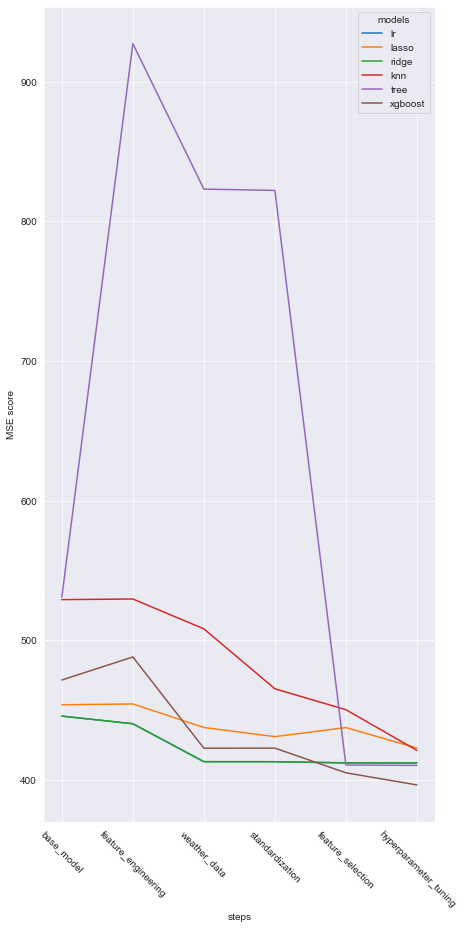

In [57]:
# Visulization the change of MSE scores
plt.figure(figsize=(7, 15))
sns.lineplot(data=score_results_melt, x="steps", y="MSE score", hue="models")
plt.xticks(rotation=-45);

# Best Model

In [68]:
# The best model based on hyperparameter tuning
best_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    max_depth=10, n_estimators=25, learning_rate=0.1,
    random_state=42, n_jobs=-1)

In [31]:
# Features of importance, Xgboost
best_model = best_model.fit(X_train_atl_xgboost, y_train_atl)
X_train_atl_xgboost.columns[np.argsort(best_model.feature_importances_)[::-1]]

Index(['PRCP', 'TMIN', 'WT03', 'DEP_TIME_BLK_0800-0859', 'TAVG',
       'DEP_TIME_BLK_0900-0959', 'DEP_TIME_BLK_0600-0659',
       'DEP_TIME_BLK_1100-1159', 'DEP_TIME_BLK_1000-1059', 'WT08', 'MONTH_9',
       'MONTH_8'],
      dtype='object')

In [124]:
# Features of importance, Ridge
best_model_linear = Ridge(alpha=0.001)
best_model_linear = best_model_linear.fit(X_train_atl, y_train_atl)
coefs = pd.DataFrame({'feature': X_train_atl.columns, 'coef': best_model_linear.coef_})
coefs['coef_abs'] = np.abs(coefs['coef'])
coefs.sort_values('coef_abs', ascending=False)[:25]

,feature,coef,coef_abs
6,SNOW,28.178718,28.178718
17,WT05,-9.632178,9.632178
38,DEP_TIME_BLK_0600-0659,-6.229023,6.229023
7,SNWD,5.864433,5.864433
27,MONTH_6,5.710797,5.710797
28,MONTH_7,5.568853,5.568853
5,PRCP,5.333399,5.333399
40,DEP_TIME_BLK_0800-0859,-5.323246,5.323246
39,DEP_TIME_BLK_0700-0759,-4.608944,4.608944
55,DEP_TIME_BLK_2300-2359,4.500959,4.500959


In [125]:
# Features of importance, Ridge
best_model_linear = Ridge(alpha=0.001)
best_model_linear = best_model_linear.fit(X_train_atl, y_train_atl)
coefs = pd.DataFrame({'feature': X_train_atl.columns, 'coef': best_model_linear.coef_})
coefs[coefs['coef']>0].sort_values('coef', ascending=False)

,feature,coef
6,SNOW,28.178718
7,SNWD,5.864433
27,MONTH_6,5.710797
28,MONTH_7,5.568853
5,PRCP,5.333399
55,DEP_TIME_BLK_2300-2359,4.500959
52,DEP_TIME_BLK_2000-2059,4.071744
50,DEP_TIME_BLK_1800-1859,3.511236
51,DEP_TIME_BLK_1900-1959,3.461614
53,DEP_TIME_BLK_2100-2159,3.182030


In [126]:
coefs[coefs['coef']<0].sort_values('coef', ascending=False)

,feature,coef
10,TMIN,-0.024056
3,FLIGHT_BLK_NUM,-0.064203
31,DAY_OF_WEEK_0,-0.196270
9,TMAX,-0.240693
45,DEP_TIME_BLK_1300-1359,-0.609789
32,DAY_OF_WEEK_1,-0.654097
37,DAY_OF_WEEK_6,-0.708070
4,AWND,-0.756959
36,DAY_OF_WEEK_5,-0.758537
33,DAY_OF_WEEK_2,-0.893547


In [116]:
# Performance on testing data
features = X_train_atl_xgboost.columns
features = features[~features.isin(['MONTH_8', 'MONTH_9'])]

X_test_atl_xgboost = pd.concat(
    [X_test_atl[features], 
    pd.DataFrame({
        'MONTH_8': [0] * X_test_atl.shape[0],
        'MONTH_9': [0] * X_test_atl.shape[0]
    })],
    axis=1
)

score = cross_val_score(best_model, X_test_atl_xgboost, y_test_atl, cv=cv, scoring='neg_mean_squared_error').mean()
round(-score, 2)

294.23

In [113]:
# Learning Curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, ylab="F1-score", scorer="f1_macro",
                        cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(ylab)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scorer, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)

    plt.grid()

    #plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    #                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
    #plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    #                 test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.grid()
    plt.legend(loc="best")
    return plt

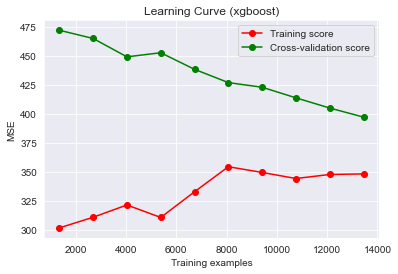

In [114]:
title = 'Learning Curve (xgboost)'
plot_learning_curve(best_model, title, X_train_atl_xgboost, y_train_atl, cv=cv, n_jobs=-1, scorer="neg_mean_squared_error", ylab='MSE');

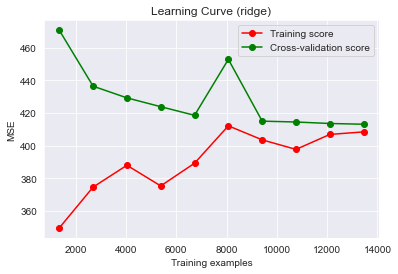

In [127]:
title = 'Learning Curve (ridge)'
plot_learning_curve(best_model_linear, title, X_train_atl, y_train_atl, cv=cv, n_jobs=-1, scorer="neg_mean_squared_error", ylab='MSE');